In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Paths
DATASET_PATH = 'Dataset'
TEST_DATASET_PATH = 'TestDataset'
# Parameters
IMAGE_SIZE = (224, 224)  # Input size for MobileNet
BATCH_SIZE = 32
EPOCHS = 20
# Load the MobileNet model pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:

# Freeze the base model layers
base_model.trainable = False
# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output layer

In [4]:

# Create the model
model = Model(inputs=base_model.input, outputs=output)
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Preprocessing for training and validation
datagen = ImageDataGenerator(
    validation_split=0.1  # 10% for validation
)
# Training set
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    subset='training'
)

# Validation set
validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    subset='validation'
)

# Test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=False
)

Found 1039 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 352 images belonging to 2 classes.


In [5]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)
# Unfreeze some base model layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers from this point

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=10,  # Adjust epochs for fine-tuning
    validation_data=validation_generator
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

C:\Users\nelis\miniconda3\envs\MLConda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 579ms/step - accuracy: 0.9208 - loss: 0.3062 - val_accuracy: 0.9737 - val_loss: 0.0599
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.9888 - loss: 0.0404 - val_accuracy: 0.9825 - val_loss: 0.0286
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 475ms/step - accuracy: 0.9951 - loss: 0.0255 - val_accuracy: 0.9912 - val_loss: 0.0268
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.9951 - loss: 0.0163 - val_accuracy: 0.9912 - val_loss: 0.0288
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 388ms/step - accuracy: 0.9983 - loss: 0.0052 - val_accuracy: 0.9825 - val_loss: 0.0299
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9825 - val_loss: 0.0256
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9825 - val_loss: 0.0187
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 1.0000 - loss: 9.9181e-04 - val_

In [6]:
# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary labels
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step


In [7]:

# Display some results
print("\nSample Predictions:")
for i in range(10):  # Display results for the first 10 test samples
    print(f"True: {true_classes[i]}, Predicted: {predicted_classes[i][0]}")
# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Sample Predictions:
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0

Classification Report:
              precision    recall  f1-score   support

       label       1.00      0.88      0.94       345
    no_label       0.15      1.00      0.25         7

    accuracy                           0.88       352
   macro avg       0.57      0.94      0.60       352
weighted avg       0.98      0.88      0.92       352



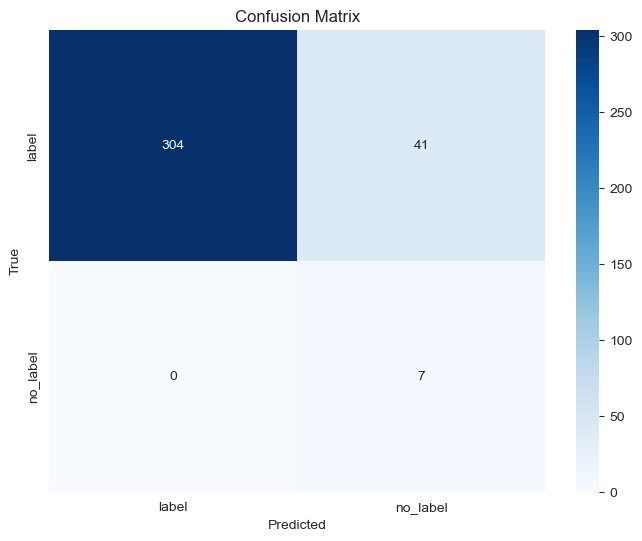

In [8]:

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()